In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [4]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [6]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cuda:0


In [8]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [9]:
import scanpy as sc

In [10]:
# atac_path = '../../../annotations/scatac/ancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
all_path = '../../../annotations/scatac/pancreas_multiome_2022_processed.h5ad'
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_atac.h5ad'
rna_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_rna.h5ad'
if not os.path.exists(atac_path):
    print('preparing atac...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    atac = adata[:,adata.var.modality == 'ATAC'].copy()
    print(atac.shape)
    atac.write(atac_path, compression='lzf')
if not os.path.exists(rna_path):
    print('preparing rna...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    rna = adata[:,adata.var.modality == 'GEX'].copy()
    print(rna.shape)
    rna.write(rna_path, compression='lzf')

In [11]:
atac = sc.read_h5ad(atac_path)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

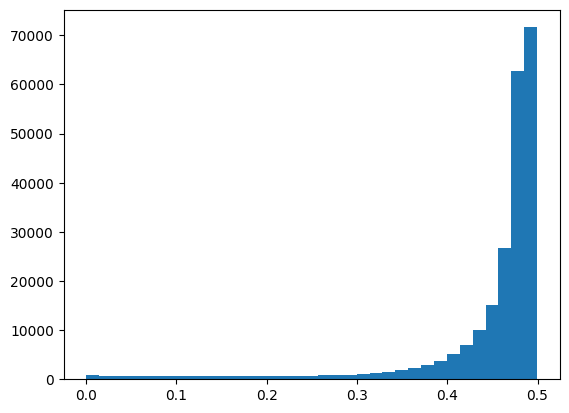

In [12]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [46]:
n_sample_cells = 250
n_sample_peaks = int(n_sample_cells * 1.5)
obs_sample = pd.Series(atac.obs_names).sample(n_sample_cells)
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(250, 375)

In [47]:
ad.obs['celltype'].value_counts(), ad.shape

(Ngn3 high            49
 Ductal               38
 Imm. Acinar          27
 Prlf. Ductal         27
 Fev+                 20
 Mat. Acinar          18
 Ngn3 low             17
 Fev+ Beta            15
 Beta                 13
 Alpha                 6
 Fev+ Alpha            6
 Eps. progenitors      4
 Epsilon               4
 Fev+ Delta            3
 Ngn3 high cycling     3
 Name: celltype, dtype: int64,
 (250, 375))

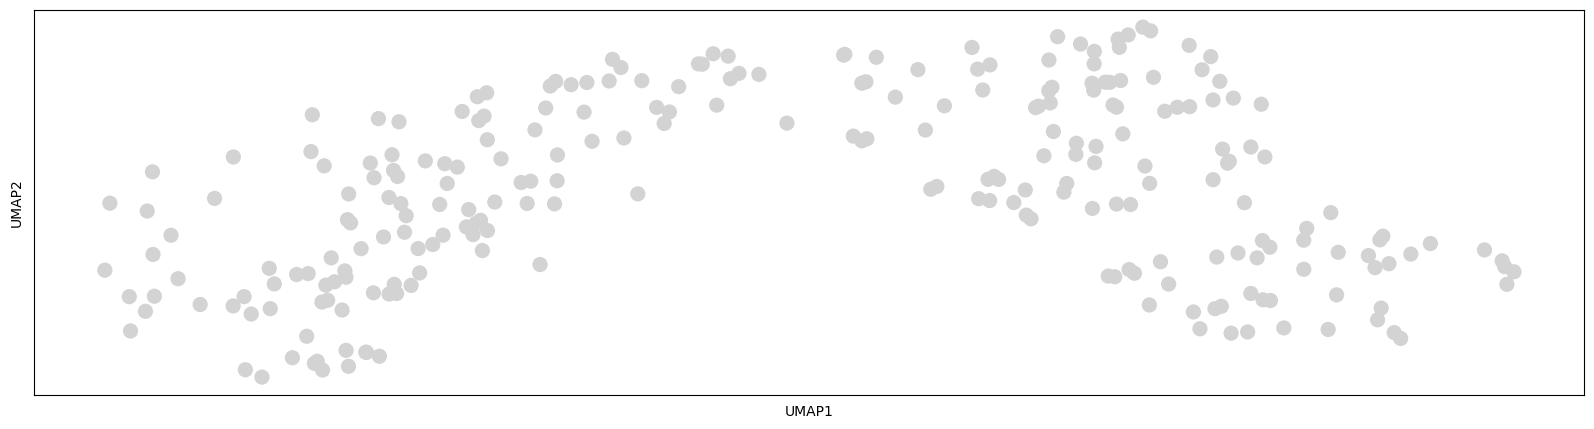

In [48]:
sc.pl.umap(ad)

In [49]:
ad.var

,modality,acc_score,acc_score_rank
1-4416461-4417378,ATAC,0.485991,65622.0
1-15878917-15879746,ATAC,0.488828,40920.5
1-17097445-17098312,ATAC,0.130689,221623.0
1-36937384-36938190,ATAC,0.423041,189062.0
1-51810069-51810814,ATAC,0.482681,88329.5
...,...,...,...
X-122825784-122826714,ATAC,0.488119,47380.0
X-137123080-137124032,ATAC,0.484454,77017.5
X-153237753-153238625,ATAC,0.431552,184165.0
X-155175323-155176232,ATAC,0.468259,140871.5


In [50]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

In [51]:
extend = 50

ad.var['chr'].value_counts()

chr2     31
chr1     28
chr4     27
chr5     27
chr6     23
chr13    23
chr3     20
chr7     20
chr8     20
chr11    19
chr10    17
chr12    17
chr9     17
chr19    15
chr16    13
chr18    13
chr14    12
chr15    12
chrX     11
chr17    10
Name: chr, dtype: int64

In [52]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [53]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmplv45xiec
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmplv45xiec -fo /tmp/tmpwims7wlt


375

In [77]:
len(seqs)

375

In [54]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [55]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [56]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [57]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(375, 251)

In [58]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [59]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [60]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [61]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,var
seq,,,,,,,,,,,,,,,,,,,,,
AATAAAAGAGCGTGAAGTTGTCTCAATACTGGGGACGCGAGTTCATTGGTTCGGCATTCTCTCATTCCAGCAAAGACCGGAACAGGAGTGAGGTTTCGGT,3.0,0.0,1.0,8.0,1.0,2.0,1.0,0.0,1.0,1.0,...,2.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.771309
CGCGTGCGACAGAGGCCGGGCGGGGCCGGGGCGGGGCCAGCTGCGCAGCACGGGGAGGAGCAGTGGCCATCGGCCCTCCCGCGAGGGGGCGGGGCCTGCG,0.0,0.0,0.0,4.0,2.0,2.0,0.0,2.0,0.0,0.0,...,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.156643
TAGGCATCACCTTCTCTATGGTTATCCCTTTCCACGCCTCCTGGCGCAGTGCACGCCGGGCAAGAGGAAGCCCTCCAGGAGCTCCCCGCGCAGCGCGGCT,0.0,0.0,2.0,2.0,0.0,3.0,3.0,1.0,0.0,1.0,...,1.0,0.0,0.0,2.0,2.0,1.0,2.0,0.0,1.0,1.080177
CTCATGAATAATGAATCGCCGGGGGGAGGGGAGGGGTCCGCCCCCCTCGGGCGGGAAGGGGGAAGCGCCGAGGCTGCCTGACTGGAATCGGGGGAGCTGC,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.774699
AGGCGCGGAACGTGCGCTCCGAGGCGCGCCGGGCGCCCTTTGCTGGCTGAGTTAGCCGAGCCGCTTCTTGAATGGGGGGCCAGGGGGCGGGGGCCCCCGC,0.0,0.0,0.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.760948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTACTTTATAAAAAATGTGTGTGTGCTTGTGTGTGTGTGGATATAGATACAAGTGGTTCCCTGTATCTTGACCTCCCTATATTTAAAAATCTTGGGTAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
TCAGAAAGGCCAGATGCTCCCTAAAGAAAATGTGTTTGATAATTGAGCTAAGGTAAATAGTCTTTGTATATTTGCATGGAGCCAGCGATTACCTGGTTTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CAGTCAGCACCATGAGTGGCCGAGTTGGAGACCTGAGCCCCAAGCAGGCAGAGACCCTGGCCAAGGTGAGAGATTCCCCCCACCCTGTACGATCTCAGGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [62]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [63]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(367, 250)

In [64]:
ad = ad[:,~zero_counts].copy()


In [65]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(91750, 3)
250
0      367
137    367
127    367
128    367
129    367
      ... 
69     367
70     367
71     367
72     367
199    367
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
AATAAAAGAGCGTGAAGTTGTCTCAATACTGGGGACGCGAGTTCATTGGTTCGGCATTCTCTCATTCCAGCAAAGACCGGAACAGGAGTGAGGTTTCGGT,1.0,3.0,0
CGCGTGCGACAGAGGCCGGGCGGGGCCGGGGCGGGGCCAGCTGCGCAGCACGGGGAGGAGCAGTGGCCATCGGCCCTCCCGCGAGGGGGCGGGGCCTGCG,1.0,0.0,0
TAGGCATCACCTTCTCTATGGTTATCCCTTTCCACGCCTCCTGGCGCAGTGCACGCCGGGCAAGAGGAAGCCCTCCAGGAGCTCCCCGCGCAGCGCGGCT,1.0,0.0,0
CTCATGAATAATGAATCGCCGGGGGGAGGGGAGGGGTCCGCCCCCCTCGGGCGGGAAGGGGGAAGCGCCGAGGCTGCCTGACTGGAATCGGGGGAGCTGC,1.0,0.0,0
AGGCGCGGAACGTGCGCTCCGAGGCGCGCCGGGCGCCCTTTGCTGGCTGAGTTAGCCGAGCCGCTTCTTGAATGGGGGGCCAGGGGGCGGGGGCCCCCGC,1.0,0.0,0


### Simple motif enrichment

In [66]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [67]:
import ushuffle

fg = df.index
bg = []

for i, s in enumerate(fg):
    # print(i, s)
    bg.append(ushuffle.shuffle(str.encode(s), 2))



In [68]:
for a, b in zip(fg, bg):
    # print(len(a[1]), len(b))
    assert len(a) == len(b)

In [69]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [70]:
reduced_groups = pwms

In [71]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [72]:
df_neg = df.copy()
df_neg.index = bg
df_neg.index = df_neg.index.astype(str)

dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


## The parameter log_dynamic defines whether a kNN-graph will be used

In [73]:
len(pwms)

286

In [85]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

setting up log dynamic
True
12
order None
0 out of 288...
break
done with mono


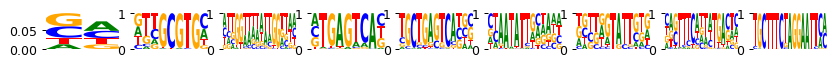

current kernels

Kernel to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 150 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 26, Loss: 260.820740, R2: 0.21,  best epoch: 24,  secs per epoch: 0.256 s,  secs epoch*1k trials: 0.698s curr time: 2023-07-20 19:33:33.310916
Epoch: 51, Loss: 244.145508, R2: 0.23,  best epoch: 49,  secs per epoch: 0.257 s,  secs epoch*1k trials: 0.700s curr time: 2023-07-20 19:33:39.748687
Epoch: 76, Loss: 227.008636, R2: 0.24,  best epoch: 74,  secs per epoch: 0.257 s,  secs epoch*1k trials: 0.701s curr time: 2023-07-20 19:33:46.198879
Epoch: 101, Loss: 212.104782, R2: 0.24,  best epoch: 99,  secs per epoch: 0.258 s,  secs epoch*1k trials: 0.702s curr time: 2023-07-20 19:33:52.667290
Epoch: 126, Loss: 200.330887, R2: 0.24,  best epoch: 124,  secs per epoch: 0.261 s,  secs epoch*1k trials: 

KeyboardInterrupt: 

In [75]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 25
log_each=25

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1, optimiser=topti.Adam,
                                                skip_kernels=list(range(1, 2)) + list(range(50, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

    break

In [ ]:
# model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
#                                             show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
#                                             opt_kernel_shift=[0, 0] + [0] * (n_kernels),
#                                             opt_kernel_length=[0, 0] + [0] * (n_kernels),
#                                             opt_one_step=True,
#                                             shift_max=1, shift_step=1, optimiser=topti.Adam,
#                                             skip_kernels=range(0, len(model.binding_modes) - 1),
#                                             n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
#                                             kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
#                                             exp_max=8,
#                                             early_stopping=250, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

True
True
3
order None
0 out of 288...
break
done with mono


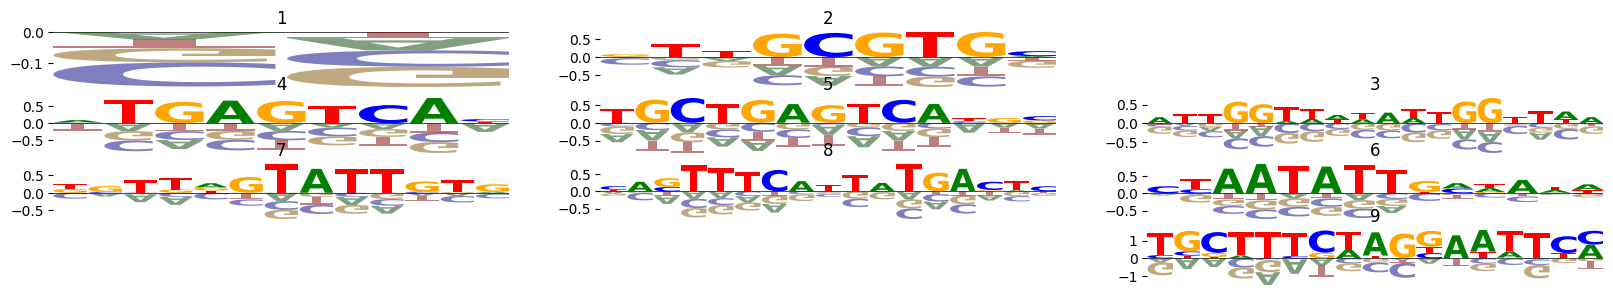

In [ ]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=10)
    plt.show()


True


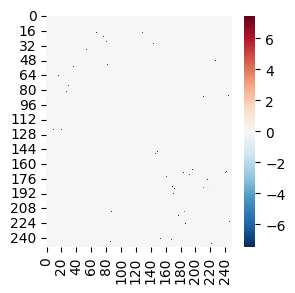

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

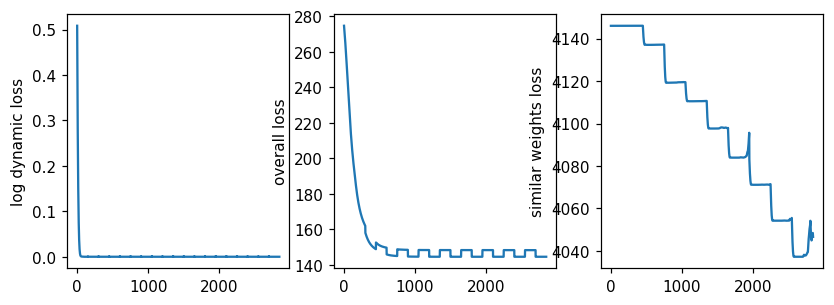

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.show()

In [ ]:
model_by_logdynamic

{True: Mubind(
   (padding): ConstantPad2d(padding=(23, 23, 0, 0), value=0.25)
   (binding_modes): BindingModesSimple(
     (conv_mono): ModuleList(
       (0): None
       (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
       (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
       (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
       (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
       (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
       (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (8): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
       (9): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
       (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
       (12): Conv2d(1, 1, kernel

True


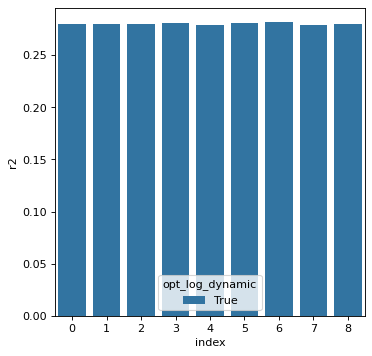

In [ ]:
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 5, 5
    rcParams['figure.dpi'] = 80
    sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic')
    plt.show()

In [ ]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [ ]:


#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
# mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
# sns.displot(dynamic_score, height=3, aspect=1.2)
# plt.xlabel('dynamic score (normalized)')


In [ ]:
ad.obs['dynamic_score'].describe()

count    250.000000
mean       0.428387
std        0.176137
min        0.000000
25%        0.428386
50%        0.428386
75%        0.428386
max        1.000000
Name: dynamic_score, dtype: float64

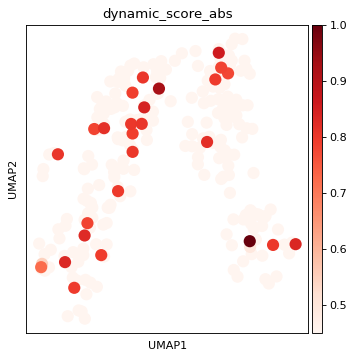

In [ ]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

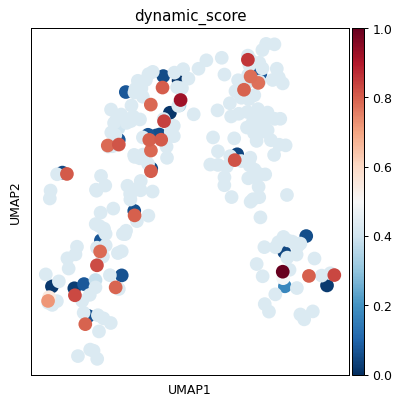

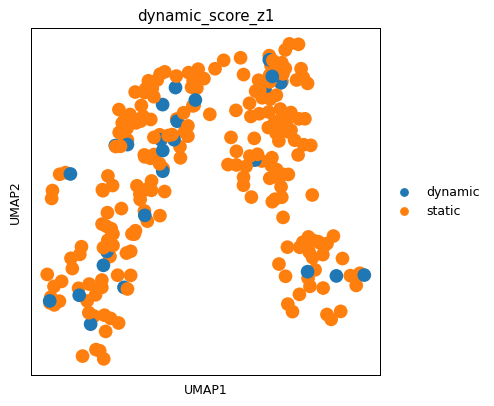

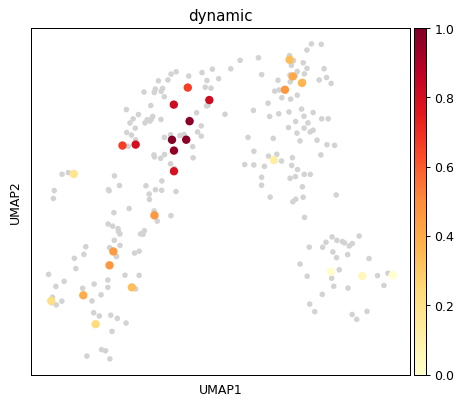

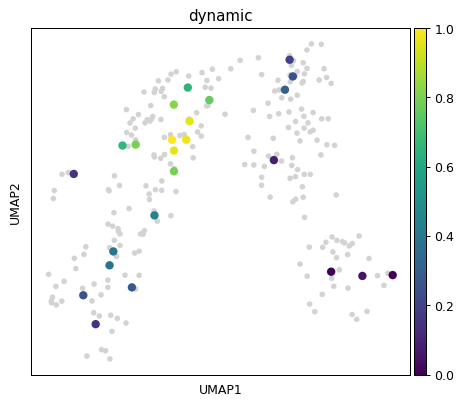

In [ ]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<AxesSubplot: >

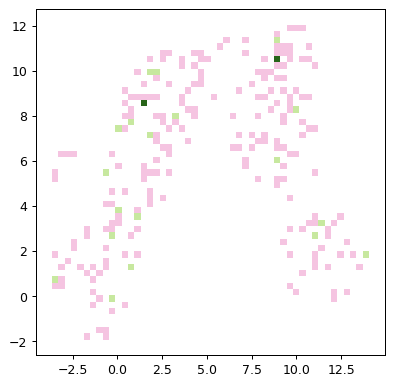

In [ ]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

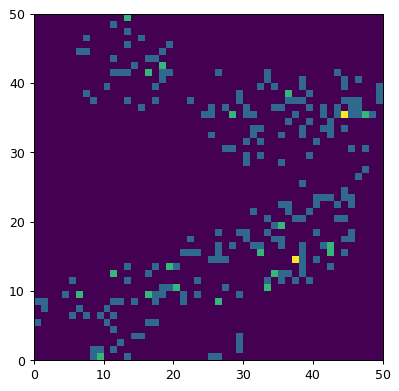

In [ ]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [ ]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [ ]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


In [ ]:
'''
ITB Physics Dept. / Python Programming Basics / Syeilendra
Generate a heatmap from xyz data file
Tested with Spyder 3.9
'''

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# ***** Main Program - Begin *****

now = datetime.now()
localtime = now.strftime("%a %d-%m-%Y %H:%M:%S")

print("2D Colored Heatmap")

# Read data from text file
array_txt = np.loadtxt("datafile1.txt",usecols=(2,3,4))
#array_txt = np.loadtxt("datafile2.txt",usecols=(2,3,4))

# x = array_txt[:,0]
# y = array_txt[:,1]
# z = array_txt[:,2]

x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)
Z=z.reshape(len(x),len(y))
Z=np.transpose(Z)
data = Z
plt.figure(figsize=(7,7), dpi=100)
#plt.contour(X, Y, Z, 7, linewidths = 0.5, colors = 'k')
plt.imshow( data , cmap = 'jet' , interpolation = 'gaussian' , origin='lower',\
           aspect='equal',  extent = [min(x), max(x), min(y), max(y)] )  
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
plt.title( "Heatmap Sample (Syeilendra ITB)", fontsize=15 )
plt.xlabel("X Label", fontsize=10)
plt.ylabel("Y Label", fontsize=10)
plt.colorbar()
plt.show()

print(f"Local time: {localtime}")

# ***** Main Program - End *****

2D Colored Heatmap


ValueError: cannot reshape array of size 250 into shape (250,250)

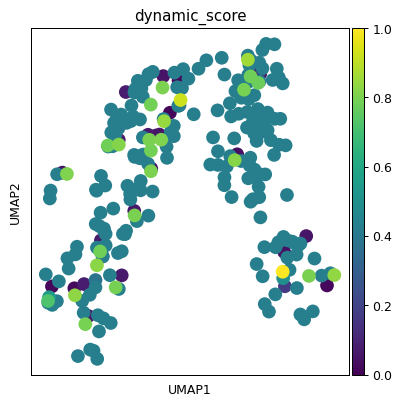

In [ ]:
sc.pl.umap(ad, color='dynamic_score')

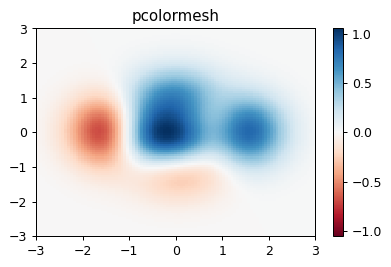

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rcParams['figure.figsize'] = 5, 3
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
# x, y = umap[:, 0], umap[:, 1]

z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# z = ad.obs['dynamic_score'].values

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
from scipy.stats import binned_statistic_2d
import numpy as np

# x = umap[:,0] # [0.1, 0.1, 0.1, 0.6]
# y = umap[:,1] # [2.1, 2.6, 2.1, 2.1]

x = [-1.1, 0.1, 0.1, 0.6]
y = [2.1, 2.6, 2.1, 2.1]

# x += abs(min(x))
# y += abs(min(y))

z = np.repeat(1, x.shape[0]) # ad.obs['dynamic_score']  # [2.,3.,5.,7.]
binx = np.arange(np.floor(min(x)), np.ceil(max(x)), 1)
biny = np.arange(0, 20, 1)
# binx = np.arange(int(min(x)), int(max(x)), 1)
# biny = np.arange(int(min(y)), int(max(y)), 1)


print(binx, biny)

ret = binned_statistic_2d(x, y, None, 'count', bins=[binx,biny], \
    expand_binnumbers=True)

print (ret.statistic)
print (ret.binnumber)
sums = np.zeros([-1+len(binx), -1+len(biny)])

for i in range(len(x)):
    m = ret.binnumber [0][i] - 1
    n = ret.binnumber [1][i] - 1

    # if len(sums) < m and len(sums[m]) < n:
    # print(m, n, z[i])
    sums[m][n] += sums[m][n] + z[i]

print (sums)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [ ]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs['celltype'].cat.codes.values, size_x=1, size_y=1)

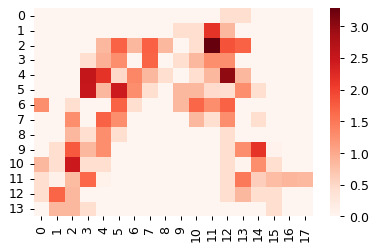

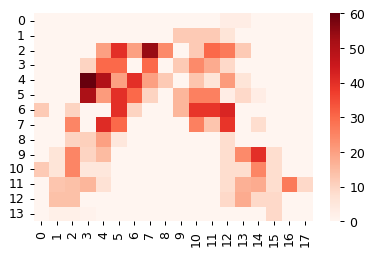

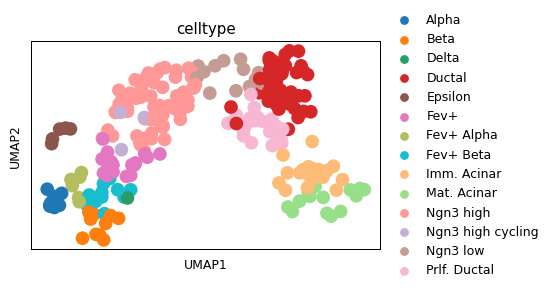

In [ ]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color='celltype')

True


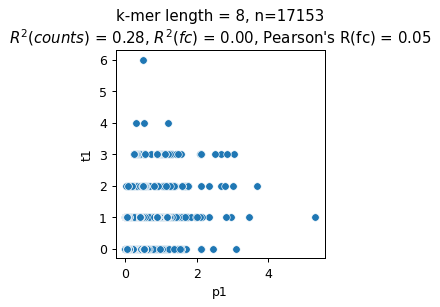

True
3
order None
0 out of 288...
10 out of 288...
break
done with mono


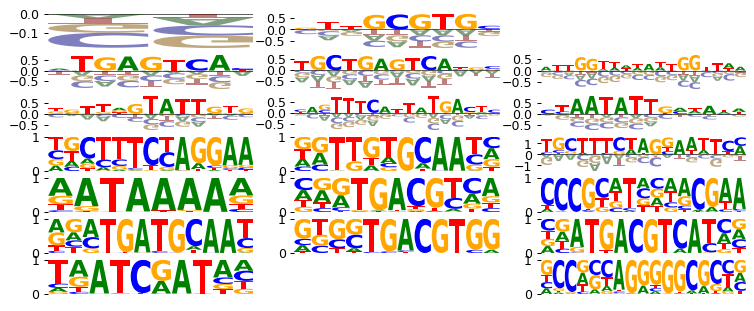

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
    plt.show()

    mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=12,
               n_cols=3,
               stop_at=20) # n_cols=len(reduced_groups))
    plt.show()


True
here...
(363, 250)
6559.0


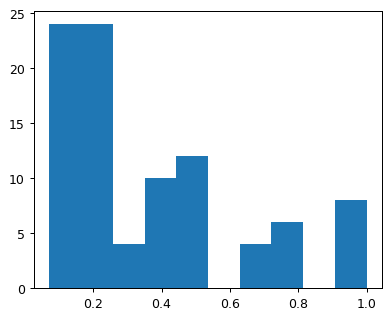

computing velocity graph (using 1/16 cores)


  0%|          | 0/250 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


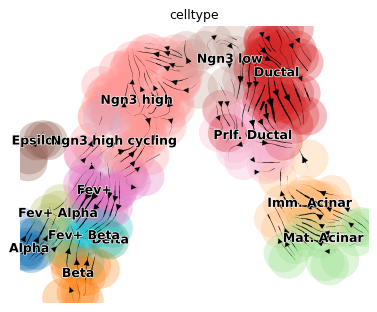

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    pred = np.concatenate(pred).T
    ad.layers['velocity'] = pred
    ad.layers['counts'] = ad.X

    mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    plt.show()

    import scvelo as scv

    sc.pp.neighbors(ad)

    scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    scv.pl.velocity_embedding_stream(ad, color='celltype') #  X_grid='X_umap', V=V)

In [ ]:
rna = sc.read_h5ad(rna_path)
rna.shape
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape
anno = mb.datasets.archetypes_anno()

In [ ]:
rna_sel.shape

(250, 14663)

True


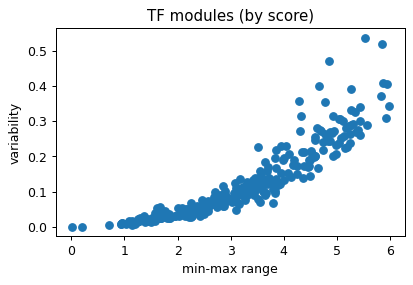

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

In [ ]:
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


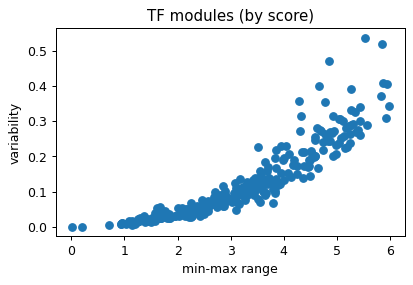

(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,) (250,)
(250,)

In [ ]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])


In [ ]:
res.sort_values('spearman', ascending=False)

,opt_log_dynamic,archetype_id,spearman,p_val
156,True,155,0.466594,6.410517e-15
90,True,89,0.459550,1.821784e-14
164,True,163,0.444614,1.543430e-13
160,True,159,0.429315,1.239246e-12
229,True,228,0.388659,1.934057e-10
...,...,...,...,...
31,True,30,-0.467321,5.747810e-15
147,True,146,-0.474143,2.037286e-15
185,True,184,-0.507252,9.434774e-18
261,True,260,-0.520758,8.858249e-19


In [ ]:
res = pd.DataFrame(pd.concat([delta, var], axis=1))
res['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
res['archetypes_name'] = res['name'].map(anno.set_index('Cluster_ID')['Name'])
res['archetypes_seed'] = res['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
res = res.sort_values(0, ascending=0)
res

,0,1,name,archetypes_name,archetypes_seed
196,5.977293,3.447274e-01,196,IRF/4,IRF7_IRF_2
47,5.952292,4.051311e-01,47,NR/18,NR1A4+RXRA_MA1146.1
198,5.927539,3.087038e-01,198,ZNF24,ZNF24_MA1124.1
197,5.878746,4.100245e-01,197,ZNF586,ZN586_HUMAN.H11MO.0.C
8,5.843867,5.181673e-01,8,HD/8,ALX1_HUMAN.H11MO.0.B
...,...,...,...,...,...
177,0.928249,7.002759e-03,177,ZNF423,Znf423_MA0116.1
3,0.925067,6.659871e-03,3,HD/3,VENTX_homeodomain_2
162,0.709837,4.151069e-03,162,REL-halfsite,MZF1_MA0056.1
dinuc_bias,0.207547,4.824322e-04,dinuc_bias,NaN,NaN


<AxesSubplot: xlabel='0', ylabel='archetypes_name'>

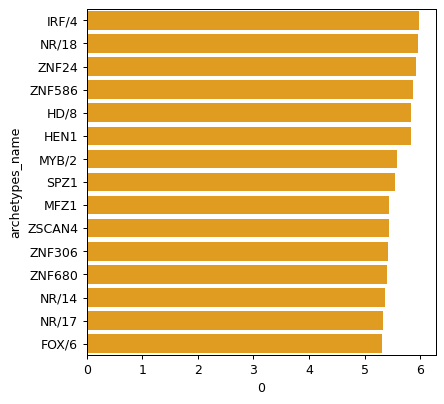

In [ ]:
rcParams['figure.figsize'] = 5, 5
sns.barplot(data=res.head(15), x=0, y='archetypes_name', color='orange')

In [ ]:
res.head(20)

,0,1,name,archetypes_name,archetypes_seed
196,5.977293,0.344727,196,IRF/4,IRF7_IRF_2
47,5.952292,0.405131,47,NR/18,NR1A4+RXRA_MA1146.1
198,5.927539,0.308704,198,ZNF24,ZNF24_MA1124.1
197,5.878746,0.410025,197,ZNF586,ZN586_HUMAN.H11MO.0.C
8,5.843867,0.518167,8,HD/8,ALX1_HUMAN.H11MO.0.B
64,5.836550,0.371139,64,HEN1,HEN1_HUMAN.H11MO.0.C
254,5.578689,0.289029,254,MYB/2,MYBL1_MYB_4
150,5.540785,0.537188,150,SPZ1,Spz1_MA0111.1
199,5.441408,0.339569,199,MFZ1,MZF1_MA0057.1
286,5.430548,0.301027,286,ZSCAN4,ZSCAN4_C2H2_1


True
1
order None
0 out of 288...
10 out of 288...
break
done with mono


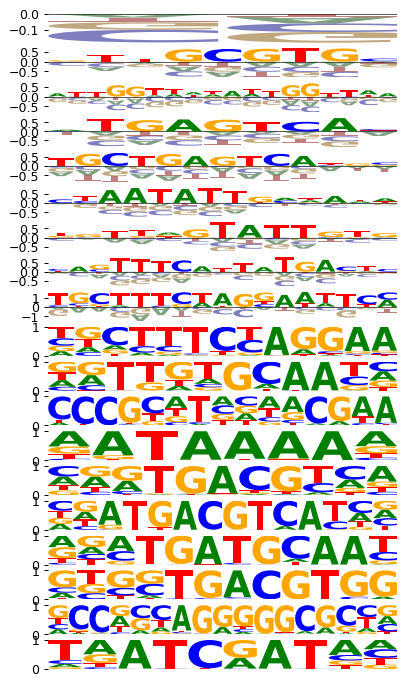

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([196,  47, 198, 197,   8,  64, 254, 150, 199, 286, 229, 251,  43,  46,
        87,  86,  82,  44, 239,  92],
      dtype='object')
0 out of 288...
10 out of 288...
done with mono


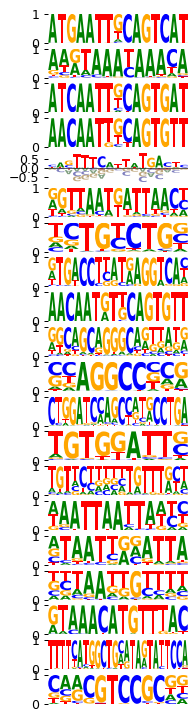

<Figure size 180x1800 with 0 Axes>

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 6.131972


In [ ]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [ ]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [ ]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [ ]:
from scipy.stats import spearmanr

In [ ]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')

res = []
print(len(all_targets))
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    log_act = ad.obsm['log_activities'][k].values
    for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
        # print(ki)
        if ki % 10 == 0:
            print(ki)
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        # for t in all_targets:
        for t in set(all_targets).intersection(next_targets):
            gex = rna_sel.X[:,rna_sel.var_names == t]
            assert gex.shape[1] == 1
            gex = gex.A.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

True


KeyboardInterrupt: 

In [ ]:
res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())

In [ ]:
res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj


In [ ]:
res

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
0,True,2,Casp7,True,-0.077185,0.014631,HD/2,0.992895,Casp7_2
1,True,2,Psen2,True,0.000150,0.996219,HD/2,0.999717,Psen2_2
2,True,2,Gen1,True,0.016710,0.597642,HD/2,0.992895,Gen1_2
3,True,2,Dusp7,True,-0.001759,0.955692,HD/2,0.997258,Dusp7_2
4,True,2,Arxes2,True,-0.025041,0.428945,HD/2,0.992895,Arxes2_2
...,...,...,...,...,...,...,...,...,...
4392,True,281,Pax6,True,-0.004904,0.876923,PAX/1,0.992895,Pax6_281
4393,True,281,Pax2,True,0.036060,0.254592,PAX/1,0.992895,Pax2_281
4394,True,283,Pax2,True,0.036060,0.254592,PAX-halfsite,0.992895,Pax2_283
4395,True,284,Ahr,True,0.008926,0.778000,AHR,0.992895,Ahr_284


In [ ]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot('k', 'opt_log_dynamic', 'spearman')


In [ ]:
res.pivot('k', 'opt_log_dynamic', 'matched')

opt_log_dynamic,True
k,
A3galt2_70,True
Aar2_248,True
Aard_248,True
Aars2_248,True
Aars_248,True
...,...
mt-Nd3_70,True
mt-Nd4_70,True
mt-Nd4l_70,True


In [ ]:
df2['matched'] = res.pivot('k', 'opt_log_dynamic', 'matched')[True]

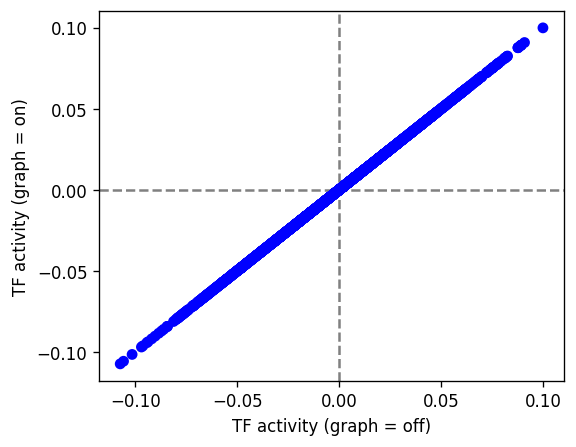

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
df2 = df2.sort_values('matched', ascending=True)
plt.scatter(df2[True], df2[True],
            color=np.where(df2['matched'], 'blue', 'gray'),
            s=np.where(df2['matched'], 30, 5))
plt.xlabel('TF activity (graph = off)')
plt.ylabel('TF activity (graph = on)')
plt.axhline(0, color='gray', ls='--', zorder=0)
plt.axvline(0, color='gray', ls='--', zorder=0)


In [ ]:
df2[df2['matched'] == True].sort_values(True, ascending=False)

opt_log_dynamic,True,matched
k,,
Atp11c_70,0.099803,True
B4galt4_70,0.090760,True
Thsd7a_70,0.089213,True
Maf_53,0.089072,True
Maf_55,0.089072,True
...,...,...
Atg4d_70,-0.096356,True
Marchf4_248,-0.097050,True
Adamts15_70,-0.101626,True


True


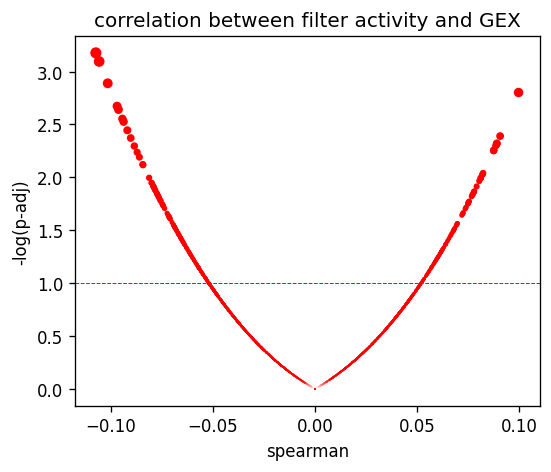

In [ ]:
for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    print(optimize_log_dynamic)
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 3), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('correlation between filter activity and GEX')
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

KeyError: 'Could not find key 96 in .var_names or .obs.columns.'

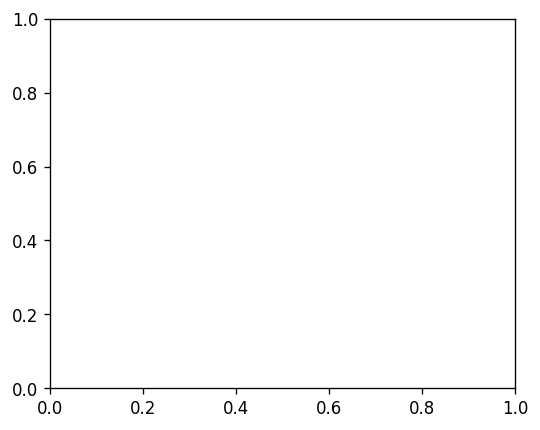

In [ ]:
sc.pl.umap(ad, color=[96], cmap='RdBu_r')
sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

In [ ]:
res[res['p_val'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
2,False,2,Gen1,True,0.154097,0.000151,HD/2,0.030184,Gen1_2
10,False,2,Mien1,True,-0.172409,0.000022,HD/2,0.006795,Mien1_2
13,False,2,Fen1,True,0.087540,0.032038,HD/2,0.493427,Fen1_2
18,False,2,Arxes2,True,-0.078467,0.054732,HD/2,0.581690,Arxes2_2
19,False,2,Tsen15,True,0.085812,0.035602,HD/2,0.507316,Tsen15_2
...,...,...,...,...,...,...,...,...,...
8707,True,248,Ermard,True,0.072471,0.076096,NR/20,0.635872,Ermard_248
8711,True,248,Narf,True,-0.073832,0.070732,NR/20,0.624434,Narf_248
8713,True,248,Arfgef2,True,-0.070181,0.085868,NR/20,0.646507,Arfgef2_248
8745,True,257,Trp53,True,-0.068231,0.094966,P53-like/1,0.661346,Trp53_257


In [ ]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

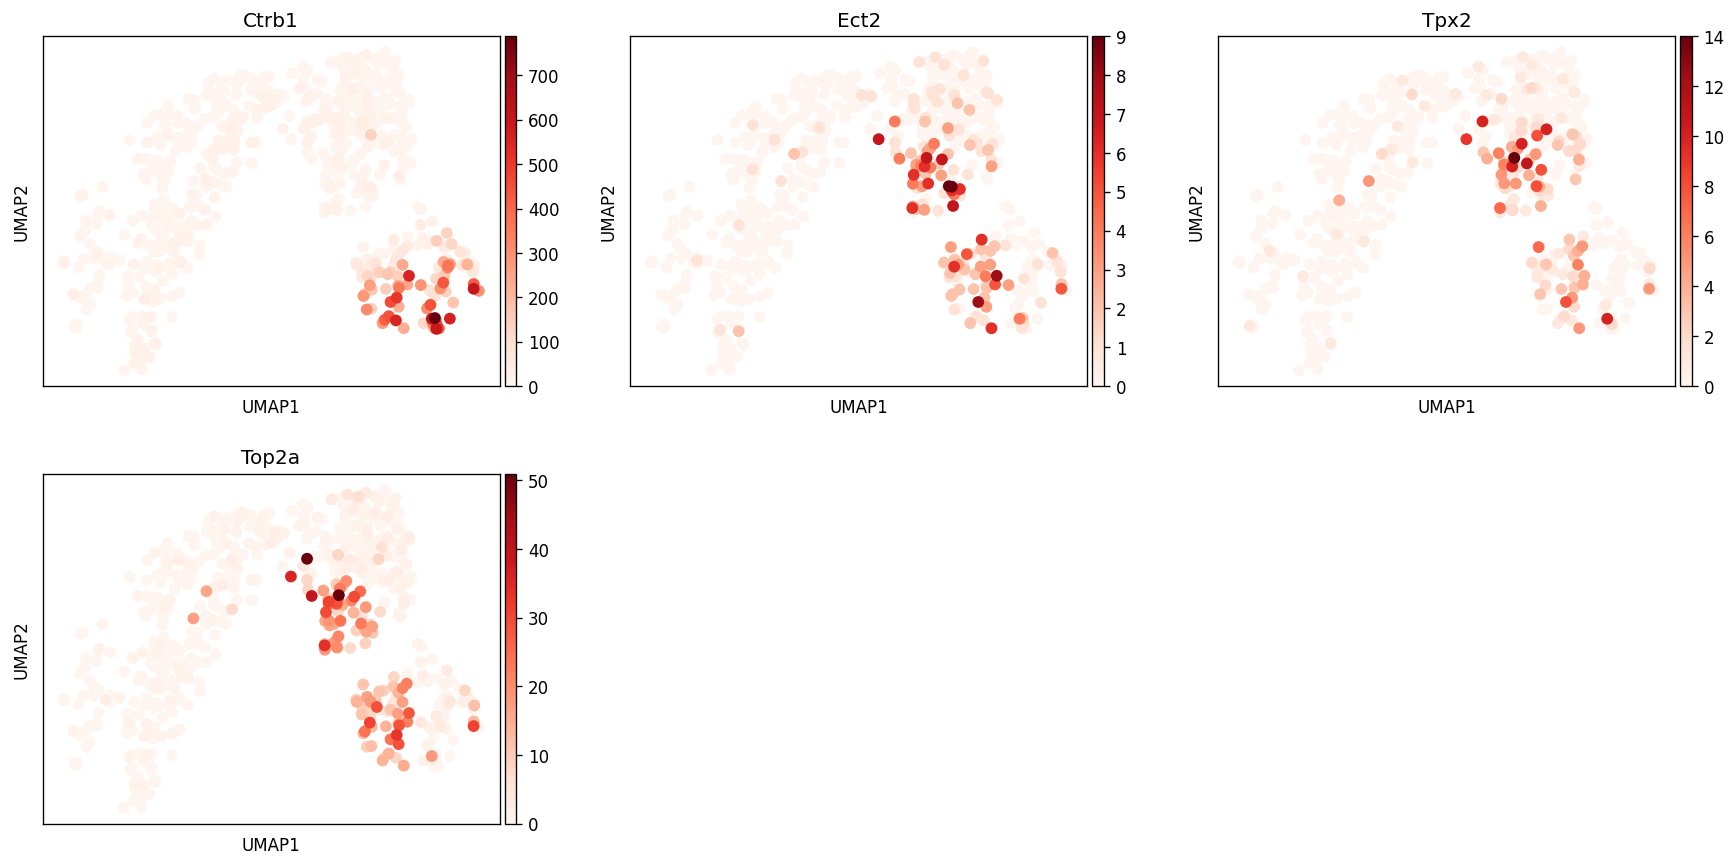

In [ ]:
sc.pl.umap(rna_sel, color=sel_genes,
           cmap='Reds', ncols=3)


In [ ]:
import anndata
ad_act = anndata.AnnData(ad.obsm['log_activities'])
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

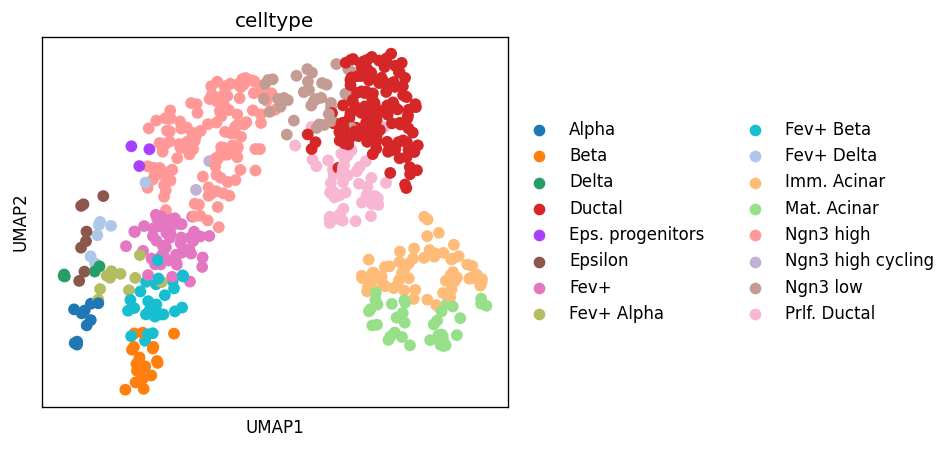

In [ ]:
sc.pl.umap(ad_act, color='celltype')


Rank genes groups using the annotation

In [ ]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
rkg_df = []
for ct in ad_act.obs['celltype'].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2['celltype'] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Ngn3 high
Fev+ Delta
Ductal
Ngn3 low
Prlf. Ductal
Imm. Acinar
Alpha
Fev+ Beta
Epsilon
Fev+ Alpha
Fev+
Ngn3 high cycling
Delta
Beta
Eps. progenitors
Mat. Acinar


,names,scores,logfoldchanges,pvals,pvals_adj,celltype,module_name
0,2,0.544601,-2.907608,0.586718,0.999883,Ngn3 high,HD/2
1,81,0.359431,NaN,0.719662,0.999883,Ngn3 high,ZNF435
2,38,0.353866,NaN,0.723814,0.999883,Ngn3 high,NR/9
3,43,0.335353,NaN,0.737670,0.999883,Ngn3 high,NR/14
4,205,0.314433,NaN,0.753523,0.999883,Ngn3 high,HD/24


Get top modules

In [ ]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

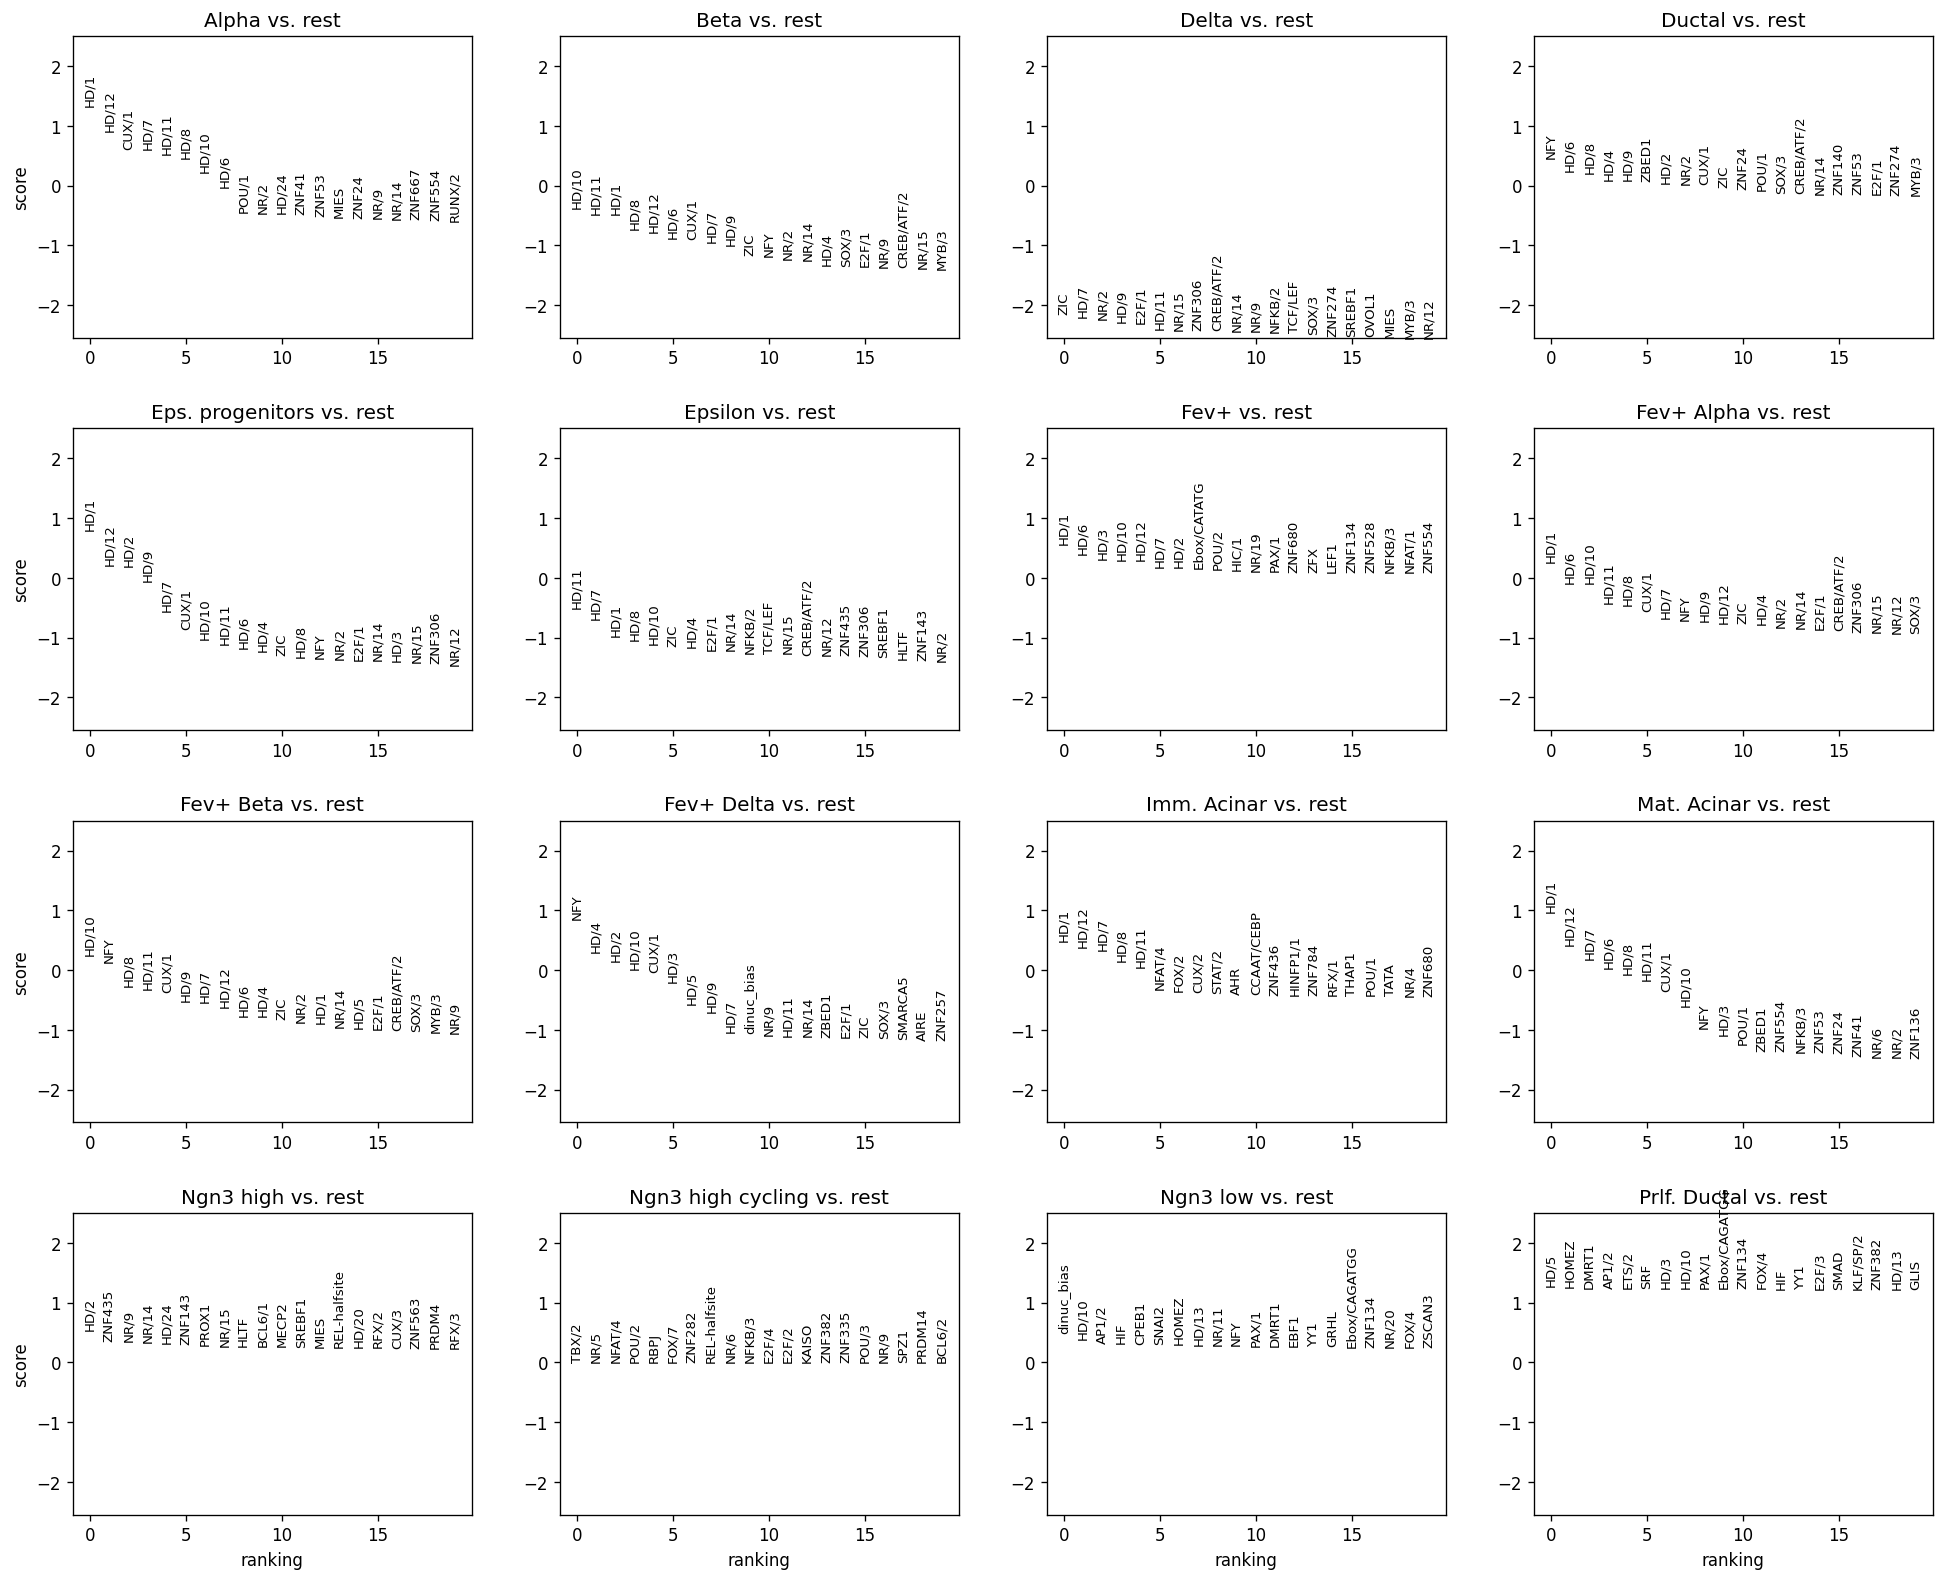

In [ ]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
sc.pl.rank_genes_groups(ad_act)


In [ ]:
len(set(res[(res['p_adj'] < 1e-5)]['k']))

4

In [ ]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Ctrb1_70', 'Ect2_70', 'Top2a_70', 'Tpx2_70'}

In [ ]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
10,False,2,Mien1,True,-0.172409,0.000022,HD/2,0.006795,Mien1_2
40,False,7,Mien1,True,-0.172409,0.000022,HD/7,0.006795,Mien1_7
2,False,2,Gen1,True,0.154097,0.000151,HD/2,0.030184,Gen1_2
35,False,7,Gen1,True,0.154097,0.000151,HD/7,0.030184,Gen1_7
65,False,19,Meis1,True,0.112268,0.005906,HD/14,0.254624,Meis1_19
...,...,...,...,...,...,...,...,...,...
11,False,2,Dusp7,True,0.000847,0.983491,HD/2,0.999160,Dusp7_2
4432,True,7,Gen1,True,0.001231,0.975994,HD/7,0.999160,Gen1_7
4399,True,2,Gen1,True,0.001231,0.975994,HD/2,0.999160,Gen1_2
4430,True,7,Men1,True,0.000171,0.996658,HD/7,0.999992,Men1_7


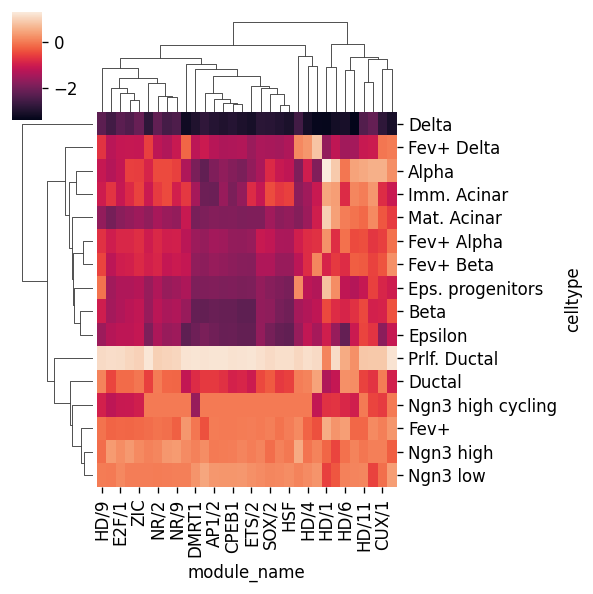

In [ ]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby('celltype').head(5)['module_name'])
sns.clustermap(rkg_df[rkg_df['module_name'].isin(mod_names_best)].pivot('celltype', 'module_name', 'scores'), figsize=[5, 5])


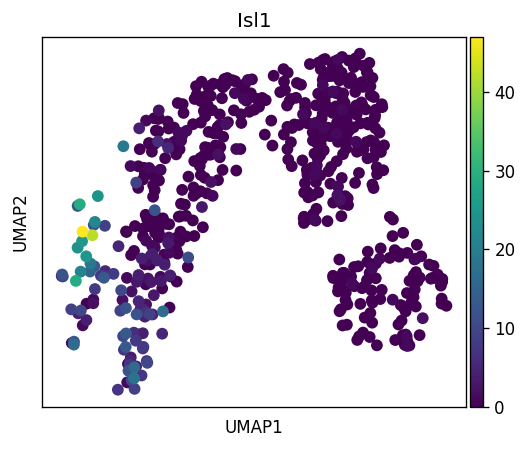

In [ ]:
sc.pl.umap(rna_sel, color='Isl1')


In [ ]:
rna_sel['Ehf']

KeyError: 'Ehf'

In [ ]:
from matplotlib import rcParams, cm
cmap = cm.get_cmap('YlOrRd')
cmap.set_over('black')
cmap.set_under('lightgray')

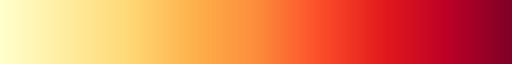

In [ ]:
cmap

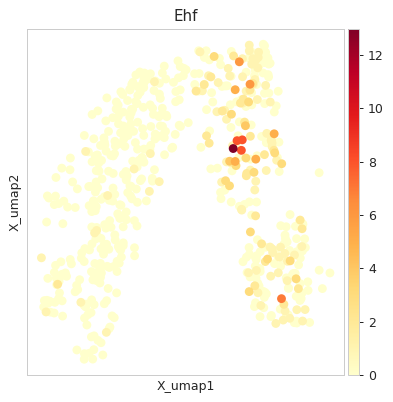

In [ ]:
sc.pl.embedding(rna_sel, basis='X_umap', color='Ehf', color_map=cmap)
